# Size of appearing/disappearing/replacement/stable chunks

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
STOPWORDS = 'exclude'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint
from progressbar import ProgressBar

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp, token_eq
from analysis.transformations import gaps
from analysis import settings

config = GistsConfiguration.get_solo()
nlp = get_nlp()

## 2 Size ~ depth

### 2.1 Setup

We need a few helper functions first

In [4]:
real_tipes = ['app', 'dis', 'apprpl', 'disrpl', 'stb']
tipes = real_tipes + ['ref']

In [5]:
def additional_features(parent, child):
    return {
        'parent_token_length': len(parent.tokens),
        'child_token_length': len(child.tokens),
        'parent_content_length': len(parent.content_tokens),
        'child_content_length': len(child.content_tokens),
    }

def base(parent, child, dal_id):
    return {
        # indices
        'tree_id': parent.tree.id,
        'parent_id': parent.id,
        'branch_id': parent.head.id if parent.parent is not None else child.head.id,
        'child_id': child.id if child is not None else np.nan,
        'dal_id': dal_id,
        # independent variables
        'depth': parent.depth,
        'is_root': parent.parent is None,
    }

def gapless(sequence, idx):
    if token_eq(sequence[idx], settings.ALIGNMENT_GAP_CHAR):
        raise ValueError("index {} is a gap in sequence {}"
                         .format(idx, sequence))
    return idx - int(np.sum([token_eq(el, settings.ALIGNMENT_GAP_CHAR)
                             for el in sequence[:idx]]))

def set_order_array(ids):
    return np.array(list(sorted(set(ids))), dtype=int)


def chunk_indices(deep_alignments):
    for dal in deep_alignments:
        seq1 = dal['seq1']
        seq2 = dal['seq2']
        subalignments = dal['subalignments']
        
        # Compute this level's app/dis/apprpl/disrpl/stb ids
        base_app_ids = []
        base_dis_ids = []
        base_apprpl_ids = []
        base_disrpl_ids = []
        base_stb_ids = []
        for i, (tok1, tok2) in enumerate(zip(seq1, seq2)):
            if token_eq(tok1, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok2, settings.ALIGNMENT_GAP_CHAR)
                base_app_ids.append(gapless(seq2, i))
            elif token_eq(tok2, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok1, settings.ALIGNMENT_GAP_CHAR)
                base_dis_ids.append(gapless(seq1, i))
            elif tok1.lemma == tok2.lemma or tok1.orth == tok2.orth:
                base_stb_ids.append(gapless(seq1, i))
            else:
                base_apprpl_ids.append(gapless(seq2, i))
                base_disrpl_ids.append(gapless(seq1, i))

        # Check we saw all the parent ids exactly once
        parent_ids = base_dis_ids + base_disrpl_ids + base_stb_ids
        assert len(set(parent_ids)) == max(parent_ids) + 1
        
        # See if that's all the work we have to do
        if len(subalignments) == 0:
            yield (set_order_array(base_app_ids),
                   set_order_array(base_dis_ids),
                   set_order_array(base_apprpl_ids),
                   set_order_array(base_disrpl_ids),
                   set_order_array(base_stb_ids))
            # Don't recurse more since there are no subalignments.
            # Instead move on to the next deep_alignment.
            break
        
        # Nope, we must combine this level with all the combinations of subalignments
        for subalignment in subalignments:
            
            if len(subalignment) == 0:
                # This subalignment is the base alignment (which was as good as
                # or better than other subalignments)
                yield (set_order_array(base_app_ids),
                       set_order_array(base_dis_ids),
                       set_order_array(base_apprpl_ids),
                       set_order_array(base_disrpl_ids),
                       set_order_array(base_stb_ids))
                continue
            
            # For this mapping, get the list of exchanges and the list of chunk_indices iterators
            # from each exchange
            excs, excs_chunk_indices_iter = zip(*[(exc, chunk_indices(exc_dals))
                                                  for exc, exc_dals in subalignment.items()])
            # Loop through the product of paths from each exchange
            for excs_chunk_indices_tuple in itertools.product(*excs_chunk_indices_iter):
                app_ids = set(base_app_ids)
                dis_ids = set(base_dis_ids)
                apprpl_ids = set(base_apprpl_ids)
                disrpl_ids = set(base_disrpl_ids)
                stb_ids = set(base_stb_ids)
                
                for (((start1, stop1), (start2, stop2)),
                     (exc_app_ids, exc_dis_ids,
                      exc_apprpl_ids, exc_disrpl_ids,
                      exc_stb_ids)) in zip(excs, excs_chunk_indices_tuple):
                
                    gapless2_start1 = gapless(seq2, start1)
                    gapless2_stop1 = gapless(seq2, stop1 - 1) + 1
                    gapless1_start2 = gapless(seq1, start2)
                    gapless1_stop2 = gapless(seq1, stop2 - 1) + 1
                    
                    app_ids.difference_update(range(gapless2_start1, gapless2_stop1))
                    dis_ids.difference_update(range(gapless1_start2, gapless1_stop2))
                    
                    app_ids.update(gapless2_start1 + exc_app_ids)
                    dis_ids.update(gapless1_start2 + exc_dis_ids)
                    apprpl_ids.update(gapless2_start1 + exc_apprpl_ids)
                    disrpl_ids.update(gapless1_start2 + exc_disrpl_ids)
                    stb_ids.update(gapless1_start2 + exc_stb_ids)
                
                yield (set_order_array(app_ids),
                       set_order_array(dis_ids),
                       set_order_array(apprpl_ids),
                       set_order_array(disrpl_ids),
                       set_order_array(stb_ids))

def contiguous_chunks(ids):
    """Get the list of contiguous chunks in `ids`.
    
    A contiguous chunk here is a suite of ids that follow each other.
    If `ids` is empty, returns a list with a single empty list element (`[[]]`)
    
    """
    
    assert len(set(ids)) == len(ids)
    ids = sorted(ids)
    if len(ids) == 0:
        return [[]]
    
    chunks = []
    chunk = [ids[0]]
    
    for id in ids[1:]:
        if id == max(chunk) + 1:
            chunk.append(id)
        else:
            chunks.append(chunk)
            chunk = [id]
    
    chunks.append(chunk)
    return chunks

def rows(parent, child):
    for i, (app_ids, dis_ids, apprpl_ids, disrpl_ids, stb_ids) in \
            enumerate(chunk_indices(parent.align_deep_lemmas(child))):

        app_chunks = contiguous_chunks(app_ids)
        dis_chunks = contiguous_chunks(dis_ids)
        apprpl_chunks = contiguous_chunks(apprpl_ids)
        disrpl_chunks = contiguous_chunks(disrpl_ids)
        stb_chunks = contiguous_chunks(stb_ids)

        for tipe, ref_sentence, chunks in [('app', child, app_chunks), ('dis', parent, dis_chunks),
                                           ('apprpl', child, apprpl_chunks), ('disrpl', parent, disrpl_chunks),
                                           ('stb', parent, stb_chunks)]:
            for chunk in chunks:
                if STOPWORDS == Sentence._SW_EXCLUDE:
                    chunk = list(filter(lambda tid: tid in ref_sentence.content_ids, chunk))
                row = base(parent, child, i)
                row.update(additional_features(parent, child))
                row.update({
                    'relatedness': Sentence._relatedness(tuple(ref_sentence.tokens[j] for j in chunk)),
                    'chunk_size': len(chunk),
                    'tipe': tipe,
                })
                yield row
    
    # Add reference measures for all possible contiguous chunks (of at least 2 words)
    # in the parent sentence
    ref_tokens = parent.content_tokens if STOPWORDS == Sentence._SW_EXCLUDE else parent.tokens
    for i in range(len(ref_tokens) - 1):
        for j in range(i + 2, len(ref_tokens) + 1):
            # -1 for 'reference dal_id'
            row = base(parent, child, -1)
            row.update(additional_features(parent, child))
            row.update({
                'relatedness': Sentence._relatedness(tuple(ref_tokens[i:j])),
                'chunk_size': j - i,
                'tipe': 'ref',
            })
            yield row

Now build the master DataFrame that we plot below

In [6]:
data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    for parent in tree.sentences.kept:

        if parent.depth >= config.target_branch_depth:
            # Ignore reformulations with out-of-shape children
            continue
        
        children = parent.children.kept
        if len(children) == 0:
            # Ignore leaves, we already saw them
            # with their parent
            continue
        
        for child in children:
            for row in rows(parent, child):
                data.append(row)

data = pd.DataFrame(data)

N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

100% (50 of 50) |#########################| Elapsed Time: 0:03:58 Time: 0:03:58


Each sentence counts for one in the plots below, so we have to weigh each row accordingly

In [7]:
data['weight'] = 1
data['weight_relatedness'] = 1 * np.isfinite(data.relatedness)
print('Computing chunk-level weight')
data['weight'] = data\
    .groupby(['parent_id', 'child_id', 'dal_id', 'tipe'])['weight']\
    .transform(lambda x: x / data.loc[x.index].weight.sum())
data['weight_relatedness'] = data\
    .groupby(['parent_id', 'child_id', 'dal_id', 'tipe'])['weight_relatedness']\
    .transform(lambda x: x / data.loc[x.index].weight_relatedness.sum())
print('Computing deep-alignment-level weight')
data['weight'] = data\
    .groupby(['parent_id', 'child_id', 'tipe'])['weight']\
    .transform(lambda x: x / data.loc[x.index].weight.sum())
data['weight_relatedness'] = data\
    .groupby(['parent_id', 'child_id', 'tipe'])['weight_relatedness']\
    .transform(lambda x: x / data.loc[x.index].weight_relatedness.sum())
# Since later on we will average for each constant depth slice,
# there is no need to scale weights according to number of sentences per tree.

Computing chunk-level weight
Computing deep-alignment-level weight


In [8]:
def plot_feature_evolution(y, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    data = kwargs['data']
    label = kwargs.get('label')
    y_depth = data.groupby('depth')[y]

    # Compute features per depth
    heights = y_depth.mean()
    cis = (y_depth.std(ddof=1)
           * stats.t.ppf(1 - .05/2, y_depth.size() - 1)
           / np.sqrt(y_depth.size()))

    # Plot
    ax = plt.gca()
    ax.plot(heights.index, heights, color=color)

    ax.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)

    if label is not None:
        # Add a dummy scatterplot so we can get legend data
        ax.scatter([], [], color=color, label=label)

### 2.2 Chunk size ~ depth

First a quick look at chunk sizes generally

In [9]:
data.loc[(data.tipe == 'app') | (data.tipe == 'apprpl'), 'chunk_size_%'] = \
    data.chunk_size / data.child_token_length
data.loc[(data.tipe == 'dis') | (data.tipe == 'disrpl') | (data.tipe == 'stb'),
         'chunk_size_%'] = \
    data.chunk_size / data.parent_token_length

In [10]:
data_chunks_size = data[data.tipe != 'ref']\
    .groupby(['parent_id', 'child_id', 'tipe',
              'depth', 'parent_token_length'], as_index=False)['chunk_size_%', 'chunk_size']\
    .aggregate(lambda x: (data.loc[x.index].weight * x).sum() / data.loc[x.index].weight.sum())

In [11]:
data_bigchunks_size = data[(data.tipe != 'ref') & (data.chunk_size >= 2)]\
    .groupby(['parent_id', 'child_id', 'tipe',
              'depth', 'parent_token_length'], as_index=False)['chunk_size_%', 'chunk_size']\
    .aggregate(lambda x: (data.loc[x.index].weight * x).sum() / data.loc[x.index].weight.sum())

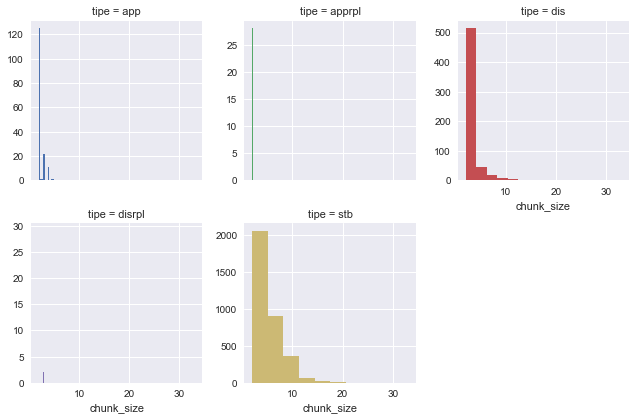

In [12]:
g = sb.FacetGrid(data_bigchunks_size, hue='tipe',
                 hue_order=sorted(real_tipes),
                 col='tipe', col_order=sorted(real_tipes), col_wrap=3,
                 sharey=False,
                 size=3)
g.map(plt.hist, 'chunk_size')

#### 2.2.1 For all chunks

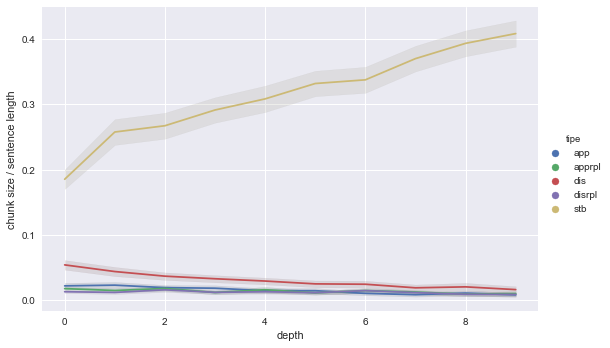

In [13]:
g = sb.FacetGrid(data_chunks_size, hue='tipe', dropna=False,
                 hue_order=sorted(real_tipes),
                 size=5, aspect=1.5)
g.map_dataframe(plot_feature_evolution, 'chunk_size_%').add_legend()
g.set_xlabels('depth')
g.set_ylabels('chunk size / sentence length')

Note that the sum of the curves should stay at about 1 (not exactly because we count appearances w.r.t. child sentence, and disappearances w.r.t. parent sentence).

The size of stable chunks grows, and the size of transformation chunks goes to 0. But, that's mainly because there are less and less, and we count a 0-sized chunk whenever there are no app/dis/apprpl/disrpl chunks. Hence the next section.

#### 2.2.2 For chunks at least 2 words long

That is, ignoring absence of chunks, and ignoring single word replacements. So really bunches of words that appear/disappear or get replaced.

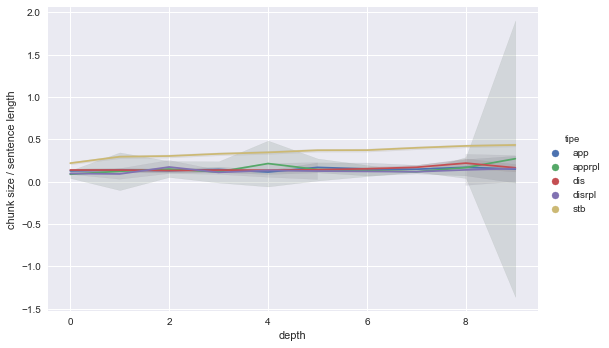

In [14]:
g = sb.FacetGrid(data_bigchunks_size, hue='tipe', dropna=False,
                 hue_order=sorted(real_tipes),
                 size=5, aspect=1.5)
g.map_dataframe(plot_feature_evolution, 'chunk_size_%').add_legend()
g.set_xlabels('depth')
g.set_ylabels('chunk size / sentence length')

The evolution of stabilities is the same. However the sizes of transformation chunks, when not counting a 0-sized chunk when no transformation happened, are in fact growing very slightly with depth, for most of them: apperances stay at the same size compared to their sentence, however disappearances and replacements grow very slowly in size relative to their sentences. This is most likely due to lowered sentence size.

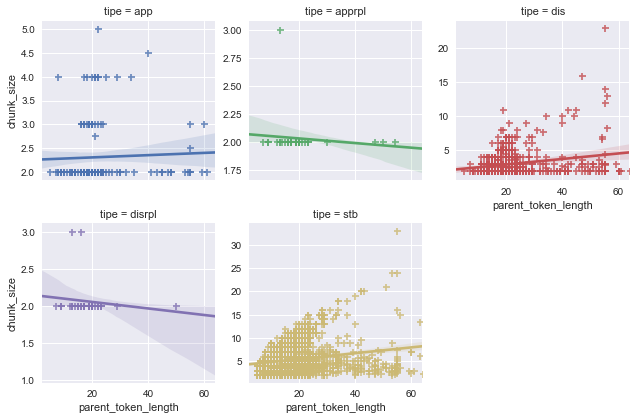

In [15]:
g = sb.FacetGrid(data_bigchunks_size, hue='tipe',
                 hue_order=sorted(real_tipes),
                 col='tipe', col_order=sorted(real_tipes), col_wrap=3,
                 sharey=False,
                 size=3)
g.map(sb.regplot, 'parent_token_length', 'chunk_size', marker='+')

Indeed: stabilities are obviously linked to sentence length, but the rest is different.
* appearances are bigger on average for longer sentences, but more scattered for shorter sentences
* disappearences are bigger with longer sentences, quite clearly
* replacement in both ways become less and less scattered

### 2.3 Chunk relatedness ~ depth (for chunks at least 2 words long)

In [16]:
data_bigchunks_relatedness = data[(data.tipe != 'ref') & (data.chunk_size >= 2)]\
    .groupby(['parent_id', 'child_id', 'tipe',
              'depth', 'parent_token_length'], as_index=False)['relatedness']\
    .aggregate(lambda x: ((data.loc[x.index].weight_relatedness * x).sum()
                          / data.loc[x.index].weight_relatedness.sum()))

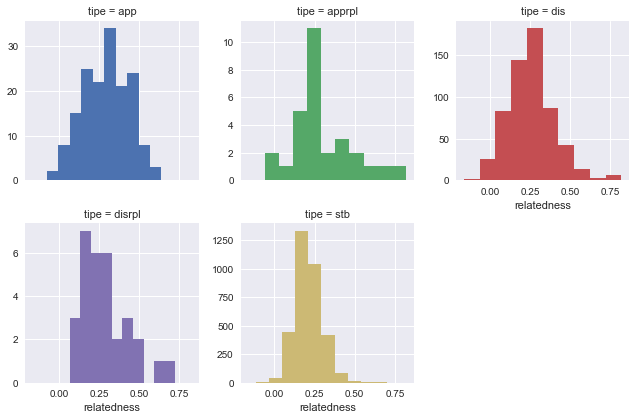

In [17]:
g = sb.FacetGrid(data_bigchunks_relatedness, hue='tipe',
                 hue_order=sorted(real_tipes),
                 col='tipe', col_order=sorted(real_tipes), col_wrap=3,
                 sharey=False,
                 size=3)
g.map(plt.hist, 'relatedness')

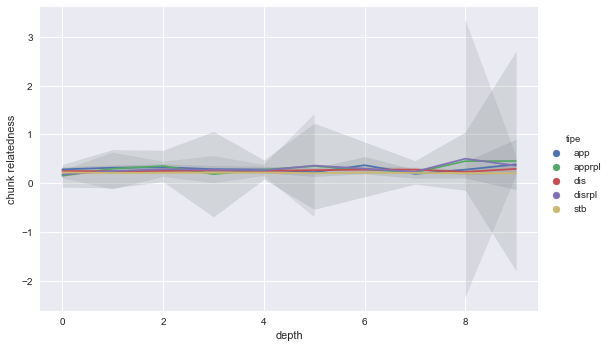

In [18]:
g = sb.FacetGrid(data_bigchunks_relatedness, hue='tipe',
                 hue_order=sorted(real_tipes),
                 size=5, aspect=1.5)
g.map_dataframe(plot_feature_evolution, 'relatedness').add_legend()
g.set_xlabels('depth')
g.set_ylabels('chunk relatedness')

### 2.4 Chunk relatedness compared to random chunks in sentences

In [19]:
def plot_bin_susties(feature, **kwargs):
    data = kwargs['data']
    data_ref = kwargs['data_ref']
    color = kwargs.get('color', 'blue')
    weight = kwargs.get('weight')
    quantiles = kwargs.get('quantiles', False)
    binning = kwargs.get('binning', 5)
    tipe = data.iloc[0].tipe
    value = data[feature]
    ref = data_ref[feature]
    if weight is None:
        if 'weight_' + feature in data.columns:
            weight = 'weight_' + feature
        else:
            print(("No specific weights found for feature '{}',"
                   " using generic weights").format(feature))
            weight = 'weight'
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(binning, 0, -1):
        try:
            ref_bins, bins = cut(ref, bin_count, labels=False,
                                 retbins=True, **cut_kws)
            value_bins = cut(value, bins, labels=False,
                             **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin heights.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[value_bins == i][weight].sum()
        h0s[i] = data_ref[ref_bins == i][weight].sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    
    # Set any null values of heigths to .5 for confints
    cis = (multinomial_proportions_confint([h or .5 for h in heights.round()],
                                            method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them
    heights[heights == 0] = np.nan
    cis[np.isnan(heights),:] = np.nan
    if tipe == 'app':
        symbol = '+'
    elif tipe == 'dis':
        symbol = '-'
    elif tipe == 'apprpl':
        symbol = 'r+'
    elif tipe == 'disrpl':
        symbol = 'r-'
    else:
        assert tipe == 'stb'
        symbol = '\sim'
    sigmaphi = r'\sigma_{\phi}^{' + symbol + '}'
    plt.plot(middles, (heights / total) / (h0s / total_h0), 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${} \mathcal{{H}}_0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.yscale('log')

In [20]:
def plot_grid(data, features, tipes, plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data, dropna=False,
                     sharex=False, sharey=True,
                     col='tipe', hue='tipe',
                     col_order=tipes, hue_order=tipes,
                     col_wrap=3, aspect=1.2, size=3)
    g.map_dataframe(plot_function, *features, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
    return g

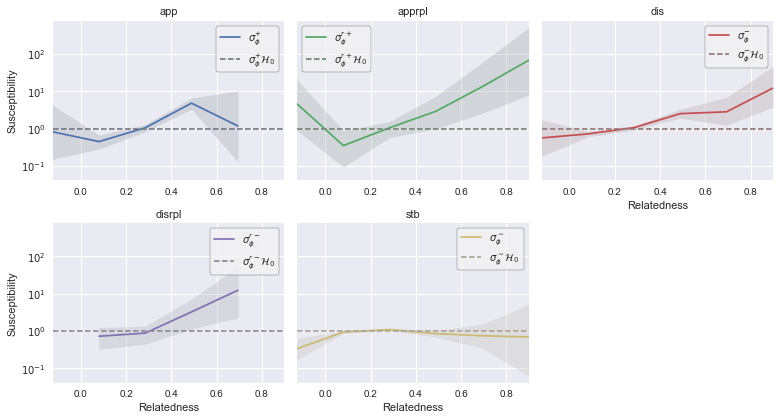

In [21]:
plot_grid(data[data.tipe != 'ref'], ['relatedness'], sorted(real_tipes), plot_bin_susties,
          'Relatedness', 'Susceptibility',
          plot_kws={'quantiles': False, 'binning': 6, 'data_ref': data[data.tipe == 'ref']})

Note that chunk size correlates slightly to relatedness, as can be seen below, but correcting for this doesn't change anything in the graphs above.

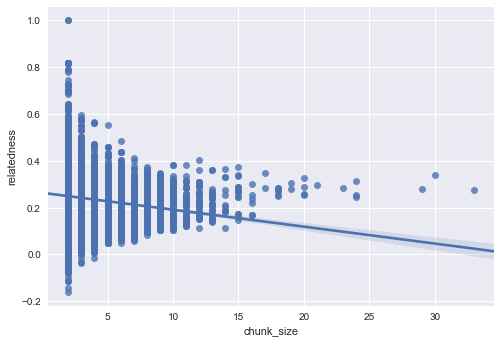

In [22]:
sb.regplot('chunk_size', 'relatedness', data[data.tipe != 'ref'])

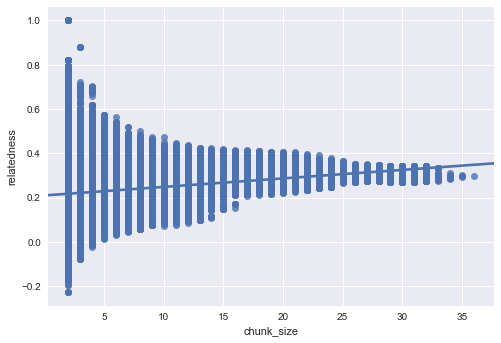

In [23]:
sb.regplot('chunk_size', 'relatedness', data)